## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gmean
#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
#Local module
import pathway_modules as pathw

## Reading all the data

#### Reading sample info and genes IDs
* Editing columns for better call
* Filtering samples in sample variable
* Read the ensemble IDs file

In [2]:
sample_info = pd.read_csv("./data_external/melanoma_data/sample.csv")
sample_info.columns = ['File_Name', 'Case_ID','Sample_ID','Sample_Type']

sample = sample_info.loc[~
    (sample_info.Sample_Type == 'Additional Metastatic')
    ]

ensembl_ids = pd.read_csv("./data_generated/ensemble.txt",
                          sep='\t',header=None).iloc[:,0]

print(sample.Sample_Type.value_counts())
print('Genes:',ensembl_ids.shape[0])

Sample_Type
Metastatic             367
Primary Tumor          103
Solid Tissue Normal      1
Name: count, dtype: int64
Genes: 60483


#### Read the expression data sample files
Create a list with all values 

In [3]:
# create empty list to store expression data from files
data_list = []
# filling the Array files data in datos21 folder
for file in sample.File_Name:
    data_read = pd.read_csv(f'./data_external/melanoma_data/datos21/{file}', sep='\t', 
                                  header=None, usecols=[1])
    data_list.append(data_read.values)

# transform in a numpy array
data_stored = np.concatenate(data_list, axis=1).T

### Transformations
- Sum 0.1 to all values 
- Get the mean values of samples

In [4]:
# sum 0.1 to avoid 0 divisions
data_stored += 0.1
# The normal sample
normalSKCM = data_stored[sample.Sample_Type == 'Solid Tissue Normal']
# Geometric mean of the primary tumor samples
tumorSKCM = gmean(data_stored[sample.Sample_Type == 'Primary Tumor'])
# Geometric mean metastatic samples
metSKCM = gmean(data_stored[sample.Sample_Type == 'Metastatic'])

### Diferenttial expression with normal and primary as references
$$e_{tumor}/e_{normal}, e_{metastatic}/e_{tumor}$$
and then create a dataframe with the logFC of differential expressed values
$$Log2(e/e_{ref})$$

In [5]:
# Diff Expression
et_en = (tumorSKCM/normalSKCM.T[:,0])
em_et = (metSKCM/tumorSKCM)
# Create DataFrame
data = np.concatenate((et_en.reshape(-1, 1),em_et.reshape(-1, 1)), 
                      axis=1)
data = pd.DataFrame(data=np.log2(data).T,columns=ensembl_ids,
                    index=['NORMALtoTUMOR','TUMORtoMETASTATIC'])

print(et_en.shape, em_et.shape)
print(data.shape)

(60483,) (60483,)
(2, 60483)


## Export means and references values

#### Export to txt files

In [6]:
np.savetxt('./data_generated/melanoma/normalSKCM.txt', normalSKCM)
np.savetxt('./data_generated/melanoma/primarySKCM.txt', tumorSKCM)
np.savetxt('./data_generated/melanoma/metSKCM.txt', metSKCM)

## Pathways

#### Load All 2233 pathways 
Get the data and filter it

In [7]:
all_pathways = pathw.pathway_query(
    "./data_external/data_pathways/All_pathways.xlsx",
    ensembl_ids)

#### Get pathway expression matrix for all 2233 pathw

In [8]:
# Non repeated pathway names
pathway_names = pd.unique(all_pathways.Pathways)

# Pathway expression matrix
P_matrix = pathw.pathway_expression(
    expression_matrix=data,
    pathway_data=all_pathways,
    pathway_names=pathway_names)

print(P_matrix.shape)

(2233, 2)


### Top 28 pathways
1 - Load data

In [9]:
top_pathways = pathw.pathway_query(
    "./data_external/data_pathways/Top28_pathways.xls",
    ensembl_ids)

2 - Get the expression matrix for 28 top pathways

In [10]:
# Non repeated pathway names
top_pathway_names = pd.unique(top_pathways.Pathways)

# Pathway expression matrix
P28_matrix = pathw.pathway_expression(
    expression_matrix=data,
    pathway_data=top_pathways,
    pathway_names=top_pathway_names)

print(P28_matrix.shape)

(28, 2)


## Graphics

#### Gene expression values count
Count genes modular expression values for Primary Tumor

In [11]:
fc_primary = abs(data.loc['NORMALtoTUMOR']).round(5).unique()
count_primary = np.array([sum(fc_primary>=values) for values in fc_primary])

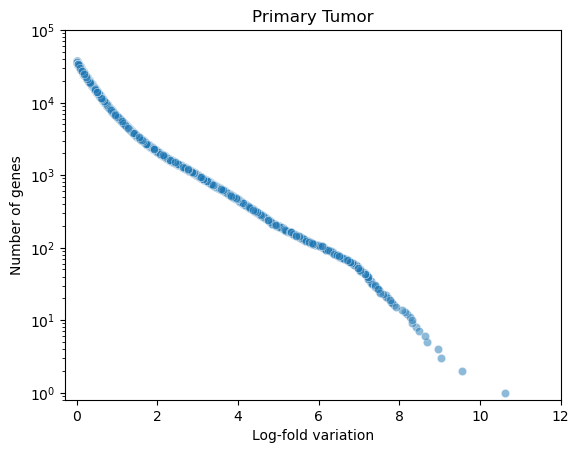

In [12]:
sns.scatterplot(x=fc_primary,y=count_primary, alpha=0.5)
# Set the y-scale to logarithmic
plt.yscale("log")

# Set limits for the x and y axes
plt.xlim(-0.3,12)
plt.ylim(0.8,100000)

# Add labels and title
plt.xlabel("Log-fold variation")
plt.ylabel("Number of genes")
plt.title("Primary Tumor")

# Store the fig
plt.savefig("./figures_tables/Fig 3a.pdf", bbox_inches='tight')

plt.show()

Count genes modular expression values for Primary Tumor

In [13]:
fc_met = abs(data.loc['TUMORtoMETASTATIC']).round(5).unique()
count_met = np.array([sum(fc_met>=values) for values in fc_met])

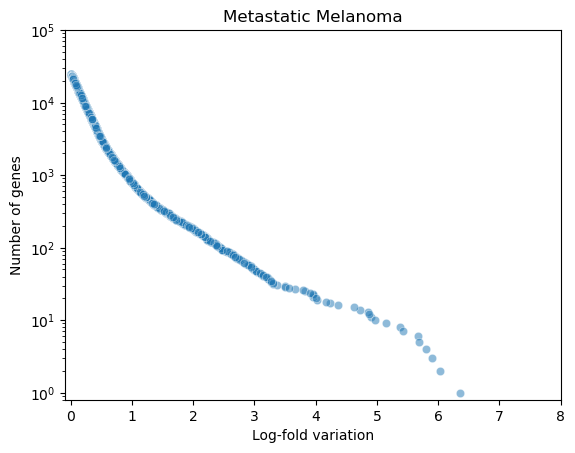

In [14]:
sns.scatterplot(x=fc_met,y=count_met, alpha=0.5)
# Set the y-scale to logarithmic
plt.yscale("log")

# Set limits for the x and y axes
plt.xlim(-0.1,8)
plt.ylim(0.8,100000)

# Add labels and title
plt.xlabel("Log-fold variation")
plt.ylabel("Number of genes")
plt.title("Metastatic Melanoma")

# Store the fig
plt.savefig("./figures_tables/Fig 3b.pdf", bbox_inches='tight')

plt.show()


#### 28 Top pathways

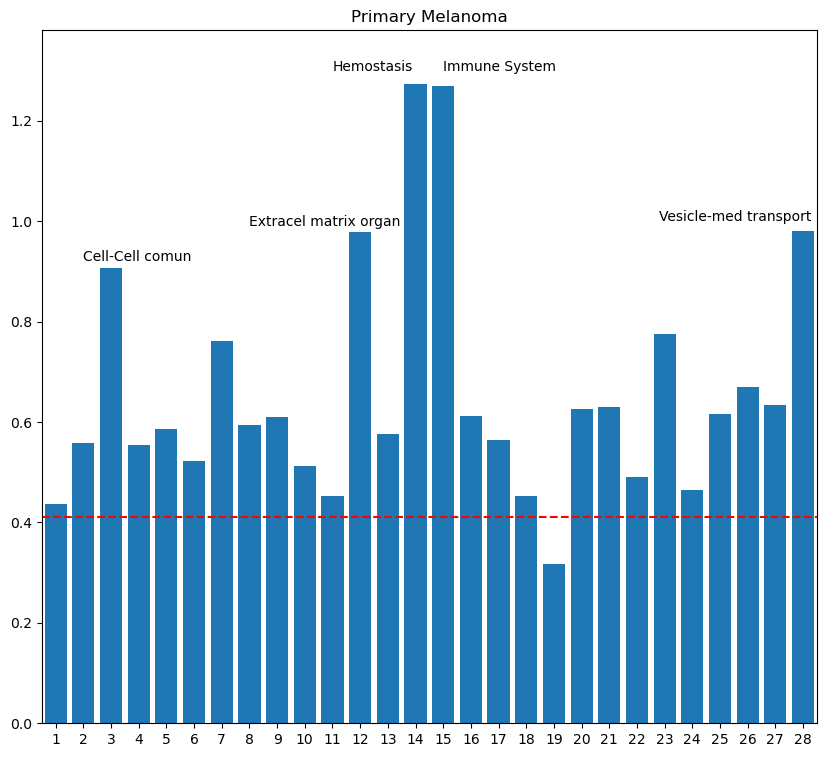

In [15]:
plt.figure(figsize=(10,9))
plt.title('Primary Melanoma')

plt.bar(np.arange(1,29),P28_matrix.NORMALtoTUMOR)
plt.axhline(abs(np.log2(et_en)).mean(),color='red',linestyle='dashed')

plt.xlim(0.5,28.5)
plt.ylim(0,1.38)
plt.xticks(np.arange(1,29))

# Annotatins
plt.annotate('Cell-Cell comun',xy=(3,0.907), xytext=(2,0.92),xycoords='data')
plt.annotate('Extracel matrix organ',xy=(12,0.97), xytext=(8,0.99),xycoords='data')
plt.annotate('Hemostasis',xy=(14,1.27), xytext=(11,1.3),xycoords='data')
plt.annotate('Immune System',xy=(15,1.26), xytext=(15,1.3),xycoords='data')
plt.annotate('Vesicle-med transport',xy=(28,0.98), xytext=(22.8,1),xycoords='data')

# Store the fig
plt.savefig("./figures_tables/Fig 4a.pdf", bbox_inches='tight')
plt.show()

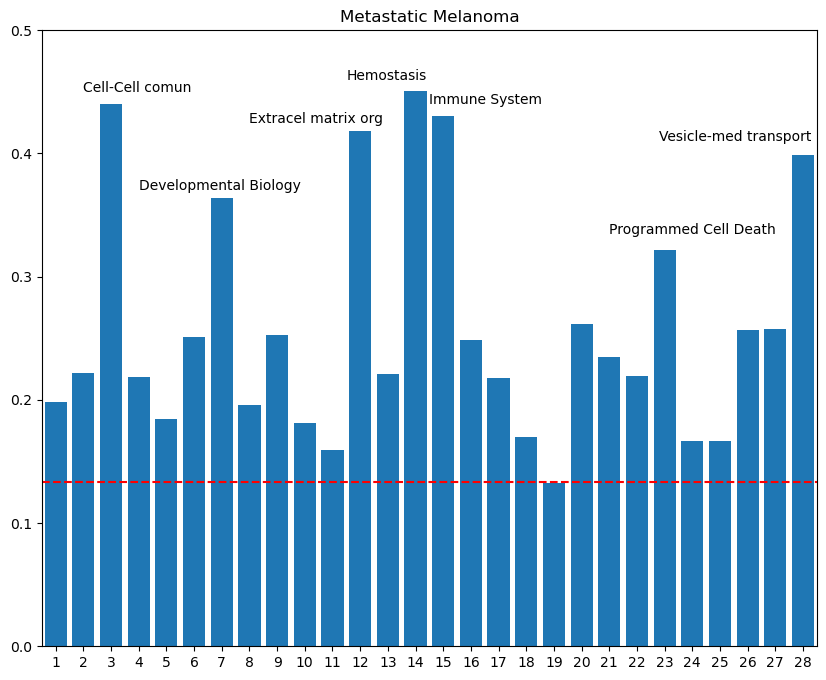

In [16]:
plt.figure(figsize=(10,8))
plt.title('Metastatic Melanoma')

plt.bar(np.arange(1,29),P28_matrix.TUMORtoMETASTATIC)
plt.axhline(abs(np.log2(em_et)).mean(),color='red',linestyle='dashed')

plt.xlim(0.5,28.5)
plt.ylim(0,0.5)
plt.xticks(np.arange(1,29))

# Annotations
plt.annotate('Cell-Cell comun',xy=(2,0.43), xytext=(2,0.45),xycoords='data')
plt.annotate('Developmental Biology',xy=(7,0.36), xytext=(4,0.37),xycoords='data')
plt.annotate('Extracel matrix org',xy=(12,0.41), xytext=(8,0.425),xycoords='data')
plt.annotate('Hemostasis',xy=(14,0.45), xytext=(11.5,0.46),xycoords='data')
plt.annotate('Immune System',xy=(15,0.43), xytext=(14.5,0.44),xycoords='data')
plt.annotate('Programmed Cell Death',xy=(23,0.32), xytext=(21,0.335),xycoords='data')
plt.annotate('Vesicle-med transport',xy=(28,0.39), xytext=(22.8,0.41),xycoords='data')

# Store the figure
plt.savefig('./figures_tables/Fig 4b.pdf')
plt.show()

In [17]:
plt.figure(figsize=(10,8))
plt.title('Metastatic Melanoma')

plt.bar(np.arange(1,2234),P_matrix.TUMORtoMETASTATIC)
plt.axhline(abs(np.log2(em_et)).mean(),color='red',linestyle='dashed')
plt.xlim(0,2234)

plt.savefig('./figures_tables/Fig 5.pdf')
plt.close()

print('Plot saved in figures and tables')

Plot saved in figures and tables


#### Most deregulated pathways table in metastatic melanoma

In [18]:
# Count genes in pathways
gene_count = pd.DataFrame(all_pathways.Pathways.value_counts())
# Get the pathways expression values
exp = P_matrix.TUMORtoMETASTATIC.loc[gene_count.index]

# Create a Data Frame with the top expressed pathways and their gene count
table5 = pd.DataFrame(
    data={
        'Expression': exp.values,'PathwayName':gene_count.index,
        'Number of Genes':all_pathways.Pathways.value_counts().values
        },
        index=np.arange(1,2234)
)
# Sort the top most deregulated
table5.sort_values(by='Expression',ascending=False,inplace=True)
# Remove pathways with less than 5 genes
table5 = table5.drop(
    table5[table5['Number of Genes']<5].index
    ).reset_index().head(30)

# Stored in figures and tables as csv file
table5.to_csv('./figures_tables/Table IV.csv')

# Show table
table5

,index,Expression,PathwayName,Number of Genes
0,1642,2.869514,Metal sequestration by antimicrobial proteins,6
1,485,1.863148,CD22 mediated BCR regulation,61
2,1395,1.774847,Type I hemidesmosome assembly,11
3,475,1.768219,Classical antibody-mediated complement activation,63
4,182,1.728352,FCGR activation,132
5,186,1.672195,Formation of the cornified envelope,130
6,426,1.637967,Scavenging of heme from plasma,69
7,173,1.604082,Role of LAT2/NTAL/LAB on calcium mobilization,136
8,421,1.602890,Creation of C4 and C2 activators,71
9,136,1.535784,Antigen activates B Cell Receptor (BCR) leadin...,163
